In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/AIH

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/AIH


In [2]:
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, dataset
import torchvision
from torchvision import transforms

In [3]:
trans = transforms.Compose([transforms.Resize((224, 224)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                            ])

trainset = torchvision.datasets.ImageFolder(root='./idenprof/train', transform = trans)
testset = torchvision.datasets.ImageFolder(root='./idenprof/test', transform = trans)

In [4]:
print("train 이미지 수: ", len(trainset))
print("class: ", trainset.classes)
classes = trainset.classes

train 이미지 수:  9000
class:  ['chef', 'doctor', 'engineer', 'farmer', 'firefighter', 'judge', 'mechanic', 'pilot', 'police', 'waiter']


In [5]:
trainloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=256, shuffle=True, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
def imshow(img):
  img = img / 2 + 0.5
  np_img = img.numpy()
  plt.figure(figsize=(20,5))
  plt.imshow(np.transpose(np_img, (1, 2, 0)))
  print(np_img.shape)
  print((np.transpose(np_img, (1,2,0))).shape)

(3, 906, 14466)
(906, 14466, 3)


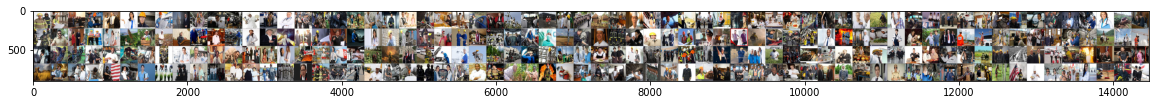

In [ ]:
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images, nrow=64))

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [8]:
import torchvision.models as models
model = models.resnet18(pretrained = False)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

model = model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
from torchsummary import summary

summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [10]:
from torch import optim
from torch.optim.lr_scheduler import StepLR

num_epochs = 50
learning_rate = 0.001
loss_func = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
scheduler = optim.lr_scheduler.LambdaLR(optimizer=opt,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,)

In [12]:
def train(model, train_loader, optimizer, log_interval):
#    for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    run_cnt = 0
#    for data in tqdm(train_loader):
    for i, data in enumerate(train_loader):
        num_of_mini_batch = len(train_loader)
        inputs, gt = data
        inputs, gt = inputs.to(device), gt.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
#        print(gt.shape)
#        print(preds.shape)

        loss = loss_func(outputs, gt)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == gt.data)
        run_cnt += len(gt)
        
        if i % log_interval == 0:
            print("[{}/{}]({:.0f}%)   Train Loss : {:.6f} ".format(i*batch_size, 
                                                               len(train_loader.dataset),
                                                               100.*i / num_of_mini_batch,
                                                               loss.item()))
            #torch.save(model.state_dict(), './my_weights.pth')
        
    cost = running_loss / len(train_loader)
    acc = (running_corrects.double() / run_cnt)*100
    train_loss_list.append(cost)
    train_acc_list.append(acc)
    
    print('train loss: %.4f, train acc: %.4f' %(cost, acc))
    torch.save(model.state_dict(), './resnet_weights.pth')

In [ ]:
train_loss_list = []
train_acc_list = []
batch_size = 256

for i in range(num_epochs):
    print("==================== EPOCH :  %d ===================="%i)
    #print('='*20,'EPOCH : ', i,'='*20)
    #print('-'*20,'TRAIN','-'*20)
    train(model, trainloader, opt, log_interval = 12)
    #print('-'*20,'TEST','-'*20)
#    test(model, test_loader, opt, logger)
    scheduler.step()

==================== EPOCH :  0 ====================
[0/9000](0%)   Train Loss : 2.411596 
